# Inspect NWB Files from DANDI Dataset 000673

This notebook helps you explore and understand the neurophysiology data from the DANDI dataset.

**Dataset Info:**
- DOI: [10.48324/dandi.000673/0.250122.0110](https://dandiarchive.org/dandiset/000673)
- Study: Control of working memory by phase–amplitude coupling of human hippocampal neurons
- Contains: Human electrophysiology data (hippocampal recordings)
- Subjects: 36 subjects
- Files: 44 NWB files (~23.4 GB total)


In [1]:
import os
from pathlib import Path
from pynwb import NWBHDF5IO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set up paths
data_root = Path("/Users/jundazhu/SBCAT/000673")

# Find all NWB files
nwb_files = list(data_root.rglob("*.nwb"))
print(f"Found {len(nwb_files)} NWB files")
print(f"\nExample files:")
for f in nwb_files[:5]:
    print(f"  {f}")

# ============================================================================
# CRITICAL: Helper function to handle transposed LFP data
# ============================================================================
def load_lfp_safe(lfp_series, n_electrodes, start_idx=0, end_idx=None):
    """
    Load LFP data handling transposition automatically.
    
    This dataset stores LFP as (channels, time) but we want (time, channels).
    
    Args:
        lfp_series: ElectricalSeries object from NWB
        n_electrodes: Number of electrodes in the dataset
        start_idx: Start timepoint index
        end_idx: End timepoint index
    
    Returns:
        lfp_data: numpy array of shape (timepoints, channels)
    
    Usage:
        lfp_series = nwbf.acquisition['LFPs']
        lfp_data = load_lfp_safe(lfp_series, len(nwbf.electrodes), 0, 10000)
        # lfp_data.shape = (10000, 70) - (time, channels)
    """
    # Access the underlying HDF5 dataset directly to avoid triggering the warning
    # This bypasses pynwb's validation that causes the warning
    h5_dataset = lfp_series._data  # Private attribute to HDF5 dataset
    raw_shape = h5_dataset.shape
    
    # If first dimension equals number of electrodes, data is (channels, time)
    if raw_shape[0] == n_electrodes:
        # Need to transpose and slice channels dimension
        return h5_dataset[:, start_idx:end_idx].T
    else:
        # Already in correct (time, channels) format
        return h5_dataset[start_idx:end_idx, :]

print("\n✓ LFP loading helper function defined (accesses HDF5 directly)")


Found 44 NWB files

Example files:
  /Users/jundazhu/SBCAT/000673/sub-13/sub-13_ses-1_ecephys+image.nwb
  /Users/jundazhu/SBCAT/000673/sub-14/sub-14_ses-1_ecephys+image.nwb
  /Users/jundazhu/SBCAT/000673/sub-22/sub-22_ses-1_ecephys+image.nwb
  /Users/jundazhu/SBCAT/000673/sub-22/sub-22_ses-2_ecephys+image.nwb
  /Users/jundazhu/SBCAT/000673/sub-22/sub-22_ses-3_ecephys+image.nwb

✓ LFP loading helper function defined (accesses HDF5 directly)


In [2]:
# Load an example NWB file
example_file = nwb_files[0]  # First file
print(f"Loading: {example_file.name}")

with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    # Basic metadata
    print("\n=== Basic Session Info ===")
    print(f"Session description: {nwbf.session_description}")
    print(f"Session start time: {nwbf.session_start_time}")
    print(f"Experimenter: {nwbf.experimenter if hasattr(nwbf, 'experimenter') else 'N/A'}")
    
    if nwbf.subject is not None:
        print(f"Subject ID: {nwbf.subject.subject_id}")
        print(f"Species: {nwbf.subject.species}")
        print(f"Age: {getattr(nwbf.subject, 'age', 'N/A')}")
        print(f"Sex: {getattr(nwbf.subject, 'sex', 'N/A')}")
    
    # Session metadata in keywords
    if nwbf.keywords:
        print(f"Keywords: {', '.join(nwbf.keywords)}")


Loading: sub-13_ses-1_ecephys+image.nwb


/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



=== Basic Session Info ===
Session description: SBCAT_ID: 13
Session start time: 2020-01-01 00:00:00-08:00
Experimenter: ('Kyzar, Michael',)
Subject ID: 13
Species: Homo sapiens
Age: P40Y
Sex: M
Keywords: single neuron, human, intracranial


In [3]:
# Inspect what data is available
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    print("\n=== Available Data Containers ===")
    
    # Acquisition (raw data streams)
    print(f"\nAcquisition ({len(nwbf.acquisition)}):")
    for key, obj in nwbf.acquisition.items():
        print(f"  - {key}: {obj.neurodata_type}")
        if hasattr(obj, 'data'):
            print(f"    Shape: {obj.data.shape}, Rate: {getattr(obj, 'rate', 'N/A')} Hz")
    
    # Processing modules (derived data)
    print(f"\nProcessing modules ({len(nwbf.processing)}):")
    for module_name, module in nwbf.processing.items():
        print(f"  - {module_name}:")
        for key, obj in module.data_interfaces.items():
            print(f"    - {key}: {obj.neurodata_type}")
    
    # Units (spike sorted neurons)
    if nwbf.units is not None:
        print(f"\nUnits table: {len(nwbf.units)} units")
    
    # Electrodes
    if nwbf.electrodes is not None:
        print(f"\nElectrodes table: {len(nwbf.electrodes)} electrodes")



=== Available Data Containers ===

Acquisition (2):
  - LFPs: ElectricalSeries
    Shape: (536108, 70), Rate: 400.0 Hz
  - events: TimeSeries
    Shape: (982,), Rate: None Hz

Processing modules (0):

Units table: 27 units

Electrodes table: 70 electrodes


In [4]:
# Examine Electrodes table (recording channels)
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    if nwbf.electrodes is not None:
        electrodes_df = nwbf.electrodes.to_dataframe()
        print("=== Electrodes Table ===")
        print(f"Number of electrodes: {len(electrodes_df)}")
        print(f"\nColumns: {list(electrodes_df.columns)}")
        print(f"\nFirst few rows:")
        print(electrodes_df.head())
        
        # Check for location/group information
        if 'group' in electrodes_df.columns:
            print(f"\nElectrode groups: {electrodes_df['group'].unique()}")
        if 'group_name' in electrodes_df.columns:
            print(f"Group names: {electrodes_df['group_name'].unique()}")
        if 'location' in electrodes_df.columns:
            print(f"Locations: {electrodes_df['location'].unique()}")


=== Electrodes Table ===
Number of electrodes: 70

Columns: ['x', 'y', 'z', 'location', 'filtering', 'group', 'group_name', 'origChannel']

First few rows:
      x      y      z                               location   filtering  \
id                                                                         
0  -1.0  27.97  27.02  dorsal_anterior_cingulate_cortex_left  300-3000Hz   
1  -1.0  27.97  27.02  dorsal_anterior_cingulate_cortex_left  300-3000Hz   
2  -1.0  27.97  27.02  dorsal_anterior_cingulate_cortex_left  300-3000Hz   
3  -1.0  27.97  27.02  dorsal_anterior_cingulate_cortex_left  300-3000Hz   
4  -1.0  27.97  27.02  dorsal_anterior_cingulate_cortex_left  300-3000Hz   

                                                group group_name  origChannel  
id                                                                             
0   NLX-microwires-1 pynwb.ecephys.ElectrodeGroup ...     micros          1.0  
1   NLX-microwires-2 pynwb.ecephys.ElectrodeGroup ...     micros       

In [5]:
# Examine Units (spike sorted neurons)
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    if nwbf.units is not None:
        units_df = nwbf.units.to_dataframe()
        print("=== Units Table ===")
        print(f"Number of units: {len(units_df)}")
        print(f"\nColumns: {list(units_df.columns)}")
        print(f"\nFirst few units:")
        print(units_df.head())
        
        # Show spike times for first unit
        first_unit_idx = units_df.index[0]
        spike_times = nwbf.units['spike_times'][first_unit_idx][:]
        print(f"\nFirst unit spike times (first 10): {spike_times[:10]}")
        print(f"Total spikes for first unit: {len(spike_times)}")
        
        if len(spike_times) > 0:
            print(f"Spike times range: {spike_times[0]:.2f}s to {spike_times[-1]:.2f}s")
            print(f"Duration: {spike_times[-1] - spike_times[0]:.2f}s")


/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


=== Units Table ===
Number of units: 27

Columns: ['spike_times', 'electrodes', 'clusterID_orig', 'waveforms', 'waveforms_mean_snr', 'waveforms_peak_snr', 'waveforms_isolation_distance', 'waveforms_mean_proj_dist']

First few units:
                                          spike_times  \
id                                                      
0   [0.88392175, 1.01617175, 1.166953, 1.18448425,...   
1   [1.52792175, 2.57892075, 7.08895, 9.27560625, ...   
2   [0.16379675, 0.2020155, 0.30573425, 0.6613905,...   
3   [1.1232655, 1.272578, 2.70848325, 3.30917075, ...   
4   [2.14179575, 2.882327, 3.098077, 3.11060825, 3...   

                                           electrodes  clusterID_orig  \
id                                                                      
0         x      y      z                         ...          1353.0   
1         x      y      z                         ...           981.0   
2         x      y      z                         ...          1211.0   
3 

/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


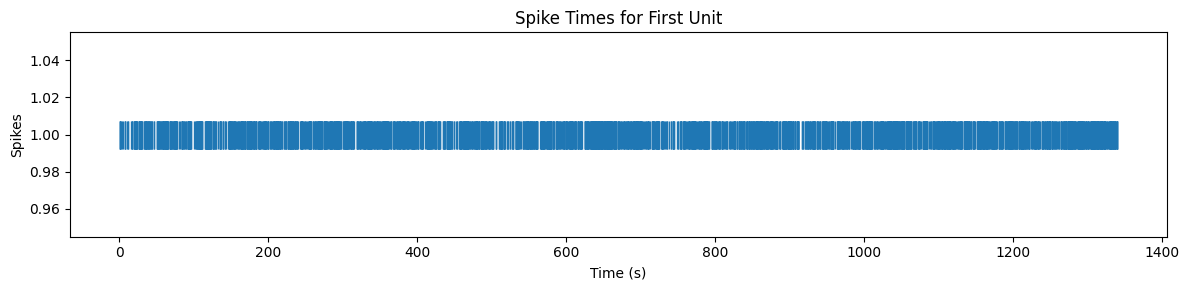

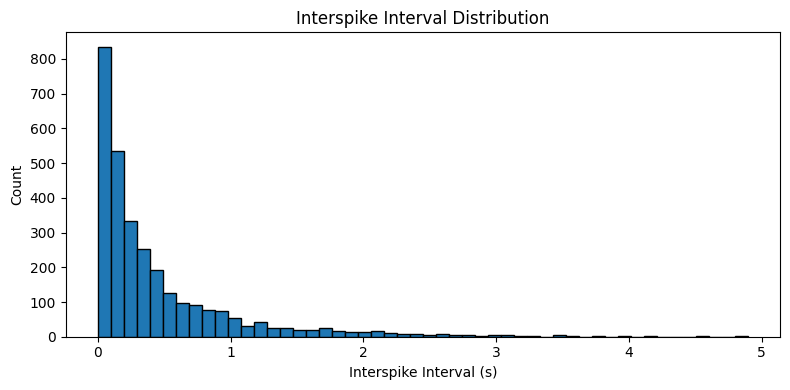

In [6]:
# Visualize spike times from first unit
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    if nwbf.units is not None:
        first_unit_idx = nwbf.units.to_dataframe().index[0]
        spike_times = nwbf.units['spike_times'][first_unit_idx][:]
        
        # Plot spike raster
        fig, ax = plt.subplots(figsize=(12, 3))
        ax.plot(spike_times, np.ones(len(spike_times)), '|', markersize=20)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Spikes')
        ax.set_title('Spike Times for First Unit')
        plt.tight_layout()
        plt.show()
        
        # Plot ISI histogram
        if len(spike_times) > 1:
            isis = np.diff(spike_times)
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.hist(isis, bins=50, edgecolor='black')
            ax.set_xlabel('Interspike Interval (s)')
            ax.set_ylabel('Count')
            ax.set_title('Interspike Interval Distribution')
            plt.tight_layout()
            plt.show()


In [7]:
# Examine macro vs micro channels
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    if nwbf.electrodes is not None:
        electrodes_df = nwbf.electrodes.to_dataframe()
        print("=== Channel Types ===")
        
        # Check for group information
        if 'group_name' in electrodes_df.columns:
            print(f"Electrode groups: {electrodes_df['group_name'].unique()}")
            
            # Count channels per group
            group_counts = electrodes_df['group_name'].value_counts()
            print(f"\nChannels per group:")
            for group, count in group_counts.items():
                print(f"  {group}: {count} channels")
        
        # Check if there are macro channels (besides micros)
        unique_groups = electrodes_df['group_name'].unique()
        print(f"\nUnique group names: {unique_groups}")
        
        if 'macros' in unique_groups or any('macro' in str(g).lower() for g in unique_groups):
            print("\n✅ MACRO channels found!")
        else:
            print("\n⚠️  Only MICROS found in this file")
        
        # Show location information
        if 'location' in electrodes_df.columns:
            print(f"\nRecording locations: {electrodes_df['location'].unique()}")


=== Channel Types ===
Electrode groups: ['micros']

Channels per group:
  micros: 70 channels

Unique group names: ['micros']

⚠️  Only MICROS found in this file

Recording locations: ['dorsal_anterior_cingulate_cortex_left'
 'pre_supplementary_motor_area_left' 'amygdala_left' 'hippocampus_left'
 'dorsal_anterior_cingulate_cortex_right'
 'pre_supplementary_motor_area_right' 'amygdala_right' 'hippocampus_right'
 'ventral_medial_prefrontal_cortex_right'
 'ventral_medial_prefrontal_cortex_left']


/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


## Plot Raw LFP from One Channel

Extract and visualize local field potential (LFP) data from a single channel


In [8]:
# Plot raw LFP from a single channel (using load_lfp_safe)
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
        nwbf = io.read()
        
        # Get LFP data
        lfp_series = nwbf.acquisition['LFPs']
        n_electrodes = len(nwbf.electrodes)
        
        # Choose a channel to plot (e.g., channel 0)
        channel_idx = 0
        print(f"Plotting LFP from channel {channel_idx}")
        
        # Load a 10-second window of data using the safe loader
        duration_seconds = 10
        n_samples = int(lfp_series.rate * duration_seconds)
        
        print(f"Loading {duration_seconds}s of data ({n_samples} samples at {lfp_series.rate} Hz)...")
        lfp_data = load_lfp_safe(lfp_series, n_electrodes, 0, n_samples)
        single_channel = lfp_data[:, channel_idx]  # Extract single channel
        
        # Create time axis in seconds
        time_axis = np.arange(len(single_channel)) / lfp_series.rate
        
        # Plot the LFP
        fig, ax = plt.subplots(figsize=(14, 5))
        ax.plot(time_axis, single_channel, linewidth=0.5, color='black')
        ax.set_xlabel('Time (s)', fontsize=12)
        ax.set_ylabel('Voltage (μV)', fontsize=12)
        ax.set_title(f'Raw LFP - Channel {channel_idx}\n({duration_seconds}s window, {lfp_series.rate} Hz)', fontsize=13)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"Data stats: min={single_channel.min():.2f} μV, max={single_channel.max():.2f} μV, mean={single_channel.mean():.2f} μV")


/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Plotting LFP from channel 0
Loading 10s of data (4000 samples at 400.0 Hz)...


AttributeError: 'ElectricalSeries' object has no attribute '_data'

/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Available locations: ['dorsal_anterior_cingulate_cortex_left'
 'pre_supplementary_motor_area_left' 'amygdala_left' 'hippocampus_left'
 'dorsal_anterior_cingulate_cortex_right'
 'pre_supplementary_motor_area_right' 'amygdala_right' 'hippocampus_right'
 'ventral_medial_prefrontal_cortex_right'
 'ventral_medial_prefrontal_cortex_left']

Selected channels: [(np.int64(0), 'dorsal_anterior_cingulate_cortex_left'), (np.int64(7), 'pre_supplementary_motor_area_left'), (np.int64(14), 'amygdala_left')]


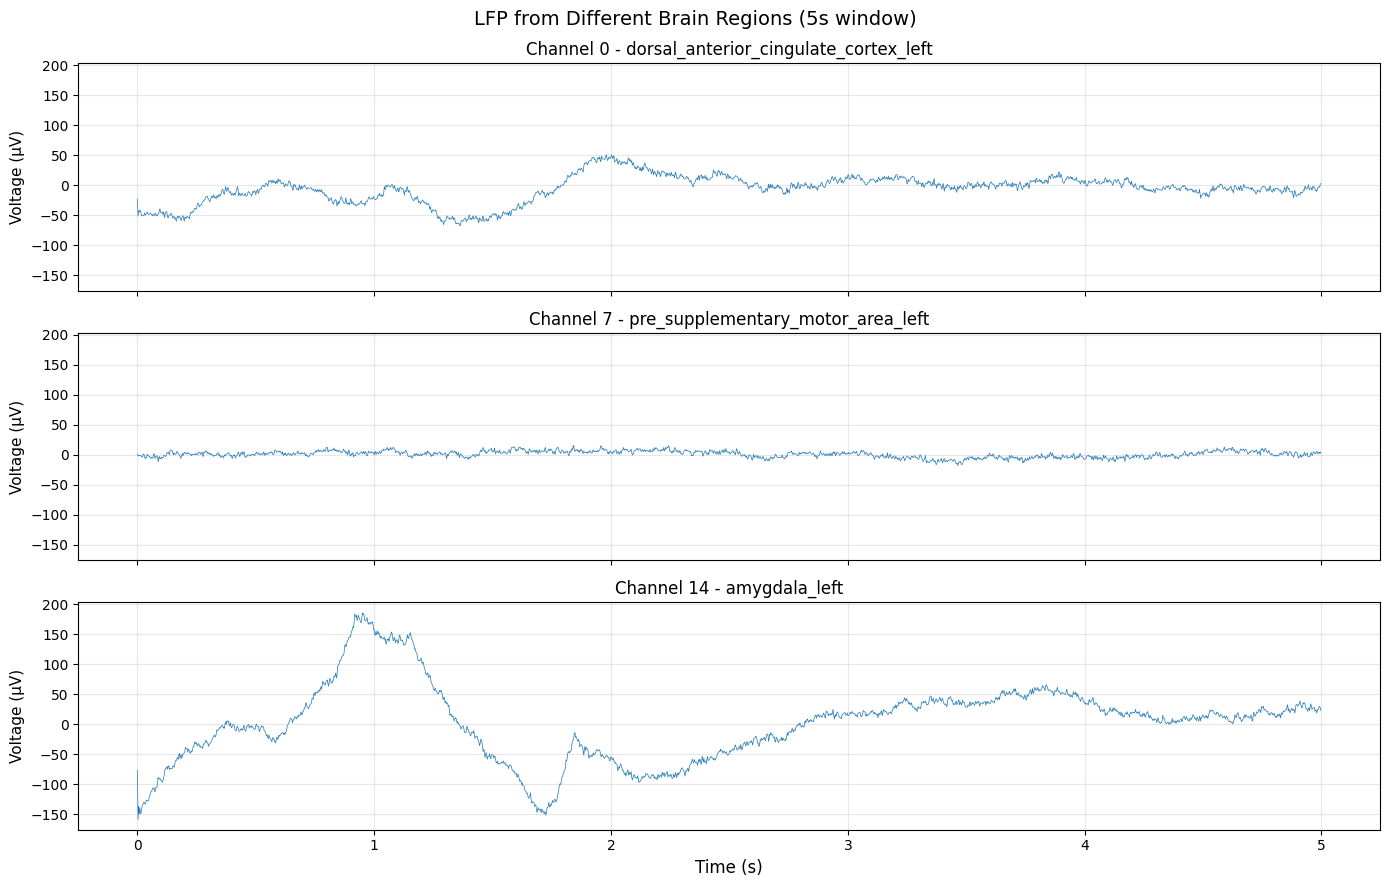

In [ ]:
# Plot multiple LFP channels from different brain regions
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    lfp_series = nwbf.acquisition['LFPs']
    electrodes_df = nwbf.electrodes.to_dataframe()
    
    # Select a few channels from different locations
    if 'location' in electrodes_df.columns:
        print("Available locations:", electrodes_df['location'].unique())
        
        # Get first channel from different locations
        unique_locations = electrodes_df['location'].unique()[:3]  # Take first 3
        selected_channels = []
        
        for loc in unique_locations:
            channels_at_loc = electrodes_df[electrodes_df['location'] == loc].index
            if len(channels_at_loc) > 0:
                selected_channels.append((channels_at_loc[0], loc))
        
        print(f"\nSelected channels: {selected_channels}")
        
        # Load 5 seconds of data from each selected channel
        duration_seconds = 5
        n_samples = int(lfp_series.rate * duration_seconds)
        
        fig, axes = plt.subplots(len(selected_channels), 1, figsize=(14, 3*len(selected_channels)), 
                                 sharex=True, sharey=True)
        
        if len(selected_channels) == 1:
            axes = [axes]
        
        for idx, (chan_idx, location) in enumerate(selected_channels):
            lfp_data = lfp_series.data[:n_samples, chan_idx]
            time_axis = np.arange(len(lfp_data)) / lfp_series.rate
            
            axes[idx].plot(time_axis, lfp_data, linewidth=0.5)
            axes[idx].set_ylabel('Voltage (μV)', fontsize=11)
            axes[idx].set_title(f'Channel {chan_idx} - {location}', fontsize=12)
            axes[idx].grid(True, alpha=0.3)
        
        axes[-1].set_xlabel('Time (s)', fontsize=12)
        plt.suptitle(f'LFP from Different Brain Regions ({duration_seconds}s window)', fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print("Location information not available in electrodes table")


/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


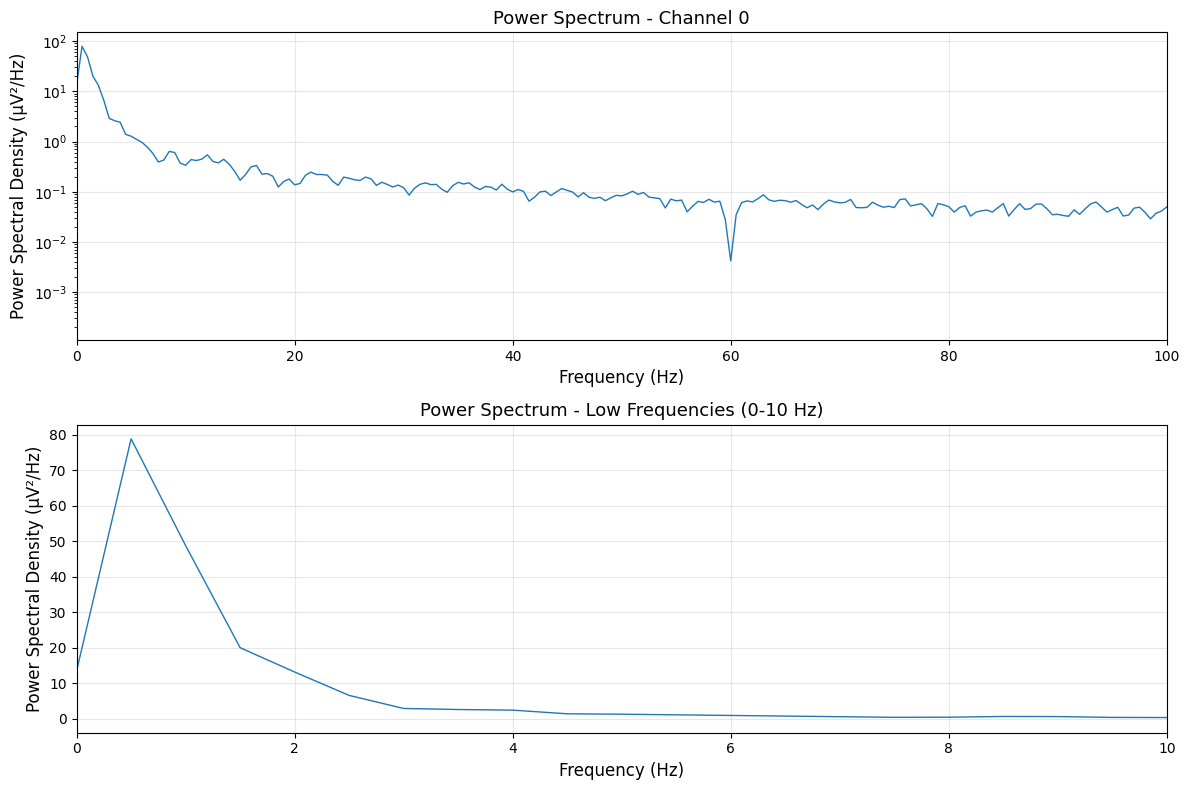

In [ ]:
# Plot LFP power spectrum (frequency domain analysis)
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    lfp_series = nwbf.acquisition['LFPs']
    channel_idx = 0
    
    # Load 30 seconds of data for spectral analysis
    duration_seconds = 30
    n_samples = int(lfp_series.rate * duration_seconds)
    
    lfp_data = lfp_series.data[:n_samples, channel_idx]
    
    # Compute power spectral density
    from scipy import signal
    
    freqs, psd = signal.welch(lfp_data, fs=lfp_series.rate, nperseg=int(lfp_series.rate * 2))
    
    # Plot spectrum
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Power spectrum (log scale)
    ax1.semilogy(freqs, psd, linewidth=1)
    ax1.set_xlabel('Frequency (Hz)', fontsize=12)
    ax1.set_ylabel('Power Spectral Density (μV²/Hz)', fontsize=12)
    ax1.set_title('Power Spectrum - Channel 0', fontsize=13)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 100)  # Focus on 0-100 Hz
    
    # Zoom in on low frequencies (typical LFP range)
    ax2.plot(freqs[:500], psd[:500], linewidth=1)
    ax2.set_xlabel('Frequency (Hz)', fontsize=12)
    ax2.set_ylabel('Power Spectral Density (μV²/Hz)', fontsize=12)
    ax2.set_title('Power Spectrum - Low Frequencies (0-10 Hz)', fontsize=13)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 10)
    
    plt.tight_layout()
    plt.show()


## Task, Events, and Trial Information

Extract behavioral task information, events, and trial structure


In [ ]:
# Inspect task and trial information
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    print("=== Task Information ===")
    print(f"Task: {getattr(nwbf, 'task', 'N/A')}")
    
    # Check intervals (trials, epochs, etc.)
    if nwbf.intervals:
        print(f"\n=== Intervals/Trials ({len(nwbf.intervals)} types) ===")
        for interval_name, interval_obj in nwbf.intervals.items():
            print(f"\n{interval_name}:")
            print(f"  Type: {interval_obj.__class__.__name__}")
            print(f"  Description: {getattr(interval_obj, 'description', 'N/A')}")
            
            # Convert to dataframe if it has to_dataframe method
            if hasattr(interval_obj, 'to_dataframe'):
                try:
                    interval_df = interval_obj.to_dataframe()
                    print(f"  Number of entries: {len(interval_df)}")
                    print(f"  Columns: {list(interval_df.columns)}")
                    print(f"\n  First few rows:")
                    print(interval_df.head())
                except Exception as e:
                    print(f"  Could not convert to dataframe: {e}")
    else:
        print("\nNo intervals/trials found in this file")
    
    # Check for session_description that might contain task info
    print("\n=== Session Description ===")
    if hasattr(nwbf, 'session_description'):
        print(nwbf.session_description)


=== Task Information ===
Task: N/A

=== Intervals/Trials (1 types) ===

trials:
  Type: TimeIntervals
  Description: Intervals for the Sternberg Task
  Number of entries: 140
  Columns: ['loads', 'PicIDs_Encoding1', 'PicIDs_Encoding2', 'PicIDs_Encoding3', 'PicIDs_Probe', 'start_time', 'stop_time', 'timestamps_FixationCross', 'timestamps_Encoding1', 'timestamps_Encoding1_end', 'timestamps_Encoding2', 'timestamps_Encoding2_end', 'timestamps_Encoding3', 'timestamps_Encoding3_end', 'timestamps_Maintenance', 'timestamps_Probe', 'timestamps_Response', 'response_accuracy', 'probe_in_out']

  First few rows:
    loads  PicIDs_Encoding1  PicIDs_Encoding2  PicIDs_Encoding3  PicIDs_Probe  \
id                                                                              
0       3               201               101               501           501   
1       3               202               102               502           502   
2       3               301               401               103     

/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


In [ ]:
# Check for event data in acquisition
with NWBHDF5IO(str(example_file), mode="r", load_namespaces=True) as io:
    nwbf = io.read()
    
    print("=== Event Data ===")
    
    for key, obj in nwbf.acquisition.items():
        if obj.neurodata_type == 'TimeSeries':
            print(f"\n{key} ({obj.neurodata_type}):")
            print(f"  Description: {getattr(obj, 'description', 'N/A')}")
            print(f"  Shape: {obj.data.shape}")
            
            # Try to load and display event data
            try:
                event_data = obj.data[:]
                print(f"  Data type: {type(event_data)}")
                if len(event_data) < 20:
                    print(f"  All values: {event_data}")
                else:
                    print(f"  First 10 values: {event_data[:10]}")
                    print(f"  Unique values: {np.unique(event_data[:50])}")
                
                # Check for timestamps
                if hasattr(obj, 'timestamps'):
                    timestamps = obj.timestamps[:]
                    print(f"  Timestamps (first 5): {timestamps[:5]}")
                    print(f"  Time range: {timestamps.min():.2f}s to {timestamps.max():.2f}s")
            except Exception as e:
                print(f"  Could not load data: {e}")


=== Event Data ===

events (TimeSeries):
  Description: The events coorespond to the TTL markers for each trial. The TTL markers are the following: 61 = Start of Experiment, 11 = Fixation Cross, 1 = Picture #1 Shown, 2 = Picture #2 Shown, 3 = Picture #3 Shown, 5 = Transition between each picture presentation, 6 = End of Encoding Sequence / Start of Maintenance Period, 7 = Probe Stimulus, 8 = Subject Response, 60 = End of Experiment 
  Shape: (982,)
  Data type: <class 'numpy.ndarray'>
  First 10 values: [61 11  1  5  2  5  3  6  7  8]
  Unique values: [ 1  2  3  5  6  7  8 11 61]
  Timestamps (first 5): [0.       0.050406 1.133656 3.14978  3.166249]
  Time range: 0.00s to 1340.27s


/Users/jundazhu/.pyenv/versions/3.10.17/lib/python3.10/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
